In [63]:
import pandas as pd
import matplotlib
import numpy as np 

import pandas as pd
import matplotlib
import numpy as np 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import warnings, gc
warnings.filterwarnings('ignore')
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv("Final_Data.csv.xls")
df = pd.DataFrame(data)
#df=df[0:99729]
print("Number of rows and columns are:")
df.shape

Number of rows and columns are:


(99730, 86)

In [3]:
df=df[0:99729]
from sklearn.model_selection import train_test_split

In [4]:
y = df["target"]
del df["target"]
X_train, X_test,y_train, y_test = train_test_split(df,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   )

X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

In [5]:
ids=X_train["Customer_id"]
ids2=X_test["Customer_id"]
del X_train["Customer_id"]
del X_test["Customer_id"]

In [59]:


rn=RandomForestClassifier(bootstrap=True,max_depth=12,max_features=3, n_estimators= 100)
rn.fit(X_train,y_train)
pred_y=rn.predict(X_test)
print("Random Forest",end=" ")
print(accuracy_score(pred_y,y_test))


Random Forest 0.8628797753935626


In [58]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [9,10, 11, 12],
    'max_features': [2, 3],
    'n_estimators': [100, 50, 30]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


{'bootstrap': True, 'max_depth': 12, 'max_features': 3, 'n_estimators': 100}

In [60]:
print('Accuracy: %.3f' % accuracy_score(y_test, pred_y))
print('Precision: %.3f' % precision_score(y_test, pred_y))
print('Recall: %.3f' % recall_score(y_test, pred_y))
print('F1: %.3f' % f1_score(y_test, pred_y))

Accuracy: 0.863
Precision: 0.733
Recall: 0.693
F1: 0.713


In [61]:
"From kaggle competition evaluation metrix"
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d),g,d

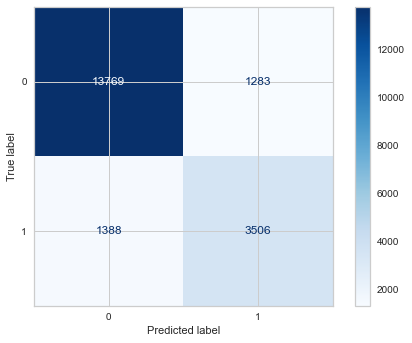

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred)
m=plot_confusion_matrix(rn, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [41]:
!pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable


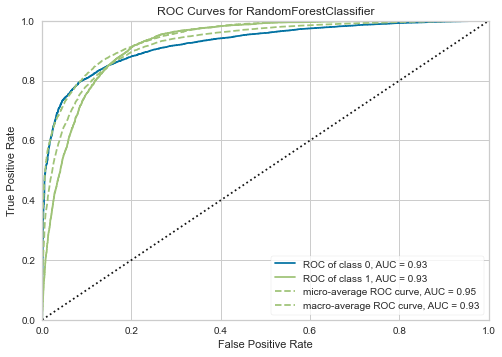

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [51]:
import yellowbrick
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(rn, classes=[0, 1])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       

In [64]:
test_y_num=np.array(y_test)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(rn.predict_proba(X_test)[:,1],columns=['prediction'])

In [65]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8499609687452615
Top 4% capture 0.4454434000817327
Final eval metric 0.6477021844134971
